In [1]:
import numpy as np

from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.metrics
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

#### Разделим выборку на обучающую и валидационную

In [2]:
(train_images, train_labels),(test_images, test_labels)=fashion_mnist.load_data()

# приведем изображение к диапазону (-1,1).
train_images = (train_images / 127) - 1
test_images = (test_images / 127) - 1

# делаем векторизацию, т.к. наши слои полносвязные и хотят на вход вектор.
train_images = train_images.reshape((-1, 784))
test_images = test_images.reshape((-1, 784))

In [3]:
train_images.shape

(60000, 784)

#### Найдем уникальные значения классов для того, чтобы узнать, сколько нейронов нужно на выходном слое

In [4]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [5]:
# Создадим модель

def create_model(n_layers, n_neurons):
    model_fm = Sequential(name=f'model_for_fashion_mnist_{n_layers}_labels')
    
    model_fm.add(Dense(n_neurons[0], activation='relu', input_shape=(784,)))
#     входной слой + поносвязный слой из указанного количества нейронов с активацией ReLU

    for layer in range(1, n_layers-1):
        model_fm.add(Dense(n_neurons[layer], activation='relu')) 

    model_fm.add(Dense(n_neurons[-1], activation='softmax'))
#     model_fm.summary()
    
    # Сохраним изначальные веса
    model_fm.save_weights(f'{model_fm}.h5')
    
    return model_fm

In [6]:
# Количество эпох
epochs = 15
epoch = np.arange(epochs)

In [7]:
def model_fashion_mnist(model_fm, layers, line, colors=None, multi_optimizer=False):
    
    if not multi_optimizer:
        model_fm.load_weights(f'{model_fm}.h5')

        # Compile the model.
        model_fm.compile(
          optimizer=Nadam(),
          loss='categorical_crossentropy',
          metrics=['accuracy'],
        )

        # проводим обучение модели 
        hh = model_fm.fit(
              train_images,
              to_categorical(train_labels),
              epochs=epochs,
              batch_size=32, validation_split=0.2, verbose = 0
              )

        plt.plot(epoch, hh.history['accuracy'], ls=line, c=colors[0], label = f'{model_fm.optimizer.get_config()["name"]} train, layers - {layers}')
        plt.plot(epoch, hh.history['val_accuracy'], ls=line, c=colors[1], label = f'{model_fm.optimizer.get_config()["name"]} test, layers - {layers}')
  
    else:
        for optimizer, color in {
            RMSprop(): ('#ff0000', '#ff6600'), 
            SGD(): ('#003300', '#009900'), 
            Adam(): ('#0000ff', '#0099ff'), 
            Nadam(): ('#ff00ff', '#ff66ff'),
        }.items():

            model_fm.load_weights(f'{model_fm}.h5')

            # Compile the model.
            model_fm.compile(
              optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'],
            )

            # проводим обучение модели 
            hh = model_fm.fit(
                  train_images,
                  to_categorical(train_labels),
                  epochs=epochs,
                  batch_size=32, validation_split=0.2, verbose = 0
                  )

            plt.plot(epoch, hh.history['accuracy'], ls='-', c=color[0], label = f'{model_fm.optimizer.get_config()["name"]} train, layers - {layers}')
            plt.plot(epoch, hh.history['val_accuracy'], ls='--', c=color[1], label = f'{model_fm.optimizer.get_config()["name"]} test, layers - {layers}')

#### Создадим несколько вариантов двуслойной модели с разным количеством нейронов в слоях

In [8]:
layers_2_v1 = (64, 128, 10)
layers_2_v2 = (128, 128, 10)
layers_2_v3 = (128, 256, 10)

model_2_v1 = create_model(2, layers_2_v1)
model_2_v2 = create_model(2, layers_2_v2)
model_2_v3 = create_model(2, layers_2_v3)

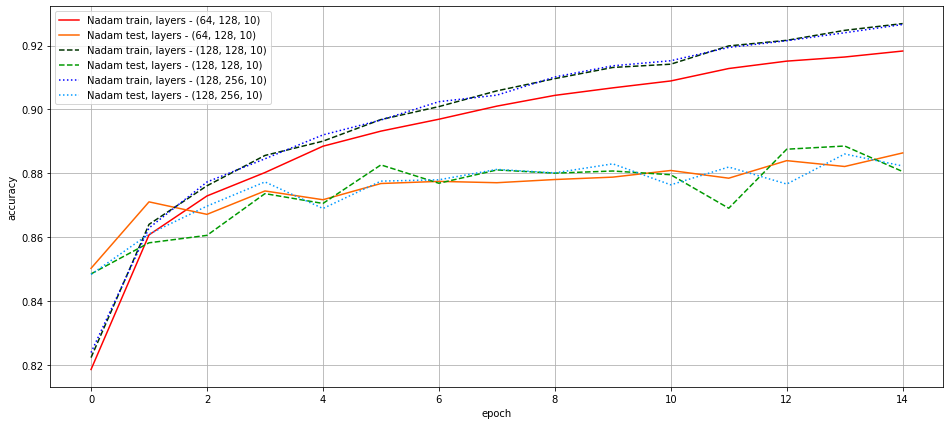

In [9]:
plt.figure(figsize=(16,7))

for model, params in {
                      model_2_v1: (layers_2_v1, '-', ('#ff0000', '#ff6600')), 
                      model_2_v2: (layers_2_v2, '--', ('#003300', '#009900')), 
                      model_2_v3: (layers_2_v3, ':', ('#0000ff', '#0099ff')),
                     }.items():
    model_fashion_mnist(model, params[0], params[1], colors=params[2])

plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

#### Четко видно различие на графике в обучающей и валидационной выборке. Лучшие результаты на обучающей показали сети с количеством нейронов (128, 256, 10) и (128, 128, 10), а вот на тестовой практически одинаково.

#### Теперь сделаем несколько моделей с разным количеством слоев

In [10]:
layers_2 = (128, 128, 10)
layers_3 = (128, 64, 42, 10)
layers_5 = (128, 64, 42, 32, 25, 10)
layers_10 = (128, 64, 42, 32, 25, 21, 18, 16, 14, 12, 10)

model_2 = create_model(2, layers_2)
model_3 = create_model(3, layers_3)
model_5 = create_model(5, layers_5)
model_10 = create_model(10, layers_10)

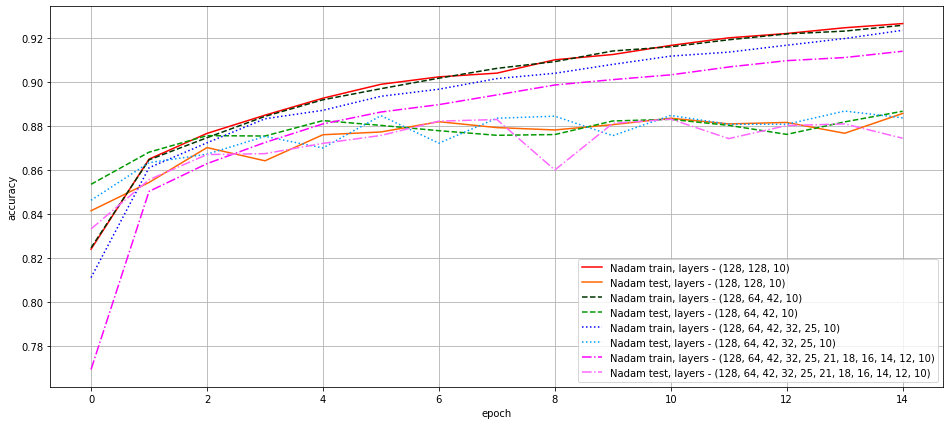

In [11]:
plt.figure(figsize=(16,7))

for model, params in {
                      model_2: (layers_2, '-', ('#ff0000', '#ff6600')), 
                      model_3: (layers_3, '--', ('#003300', '#009900')), 
                      model_5: (layers_5, ':', ('#0000ff', '#0099ff')), 
                      model_10: (layers_10, '-.', ('#ff00ff', '#ff66ff')),
                      }.items():
    model_fashion_mnist(model, params[0], params[1], colors=params[2])

plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

#### Интересный факт, чем больше было слоев, тем больше была точность на обучающей выборке. Что касается тестовой, то уровень точности у всех моделей примерно одинаковый.

#### Теперь будем варьировать оптимизаторы.

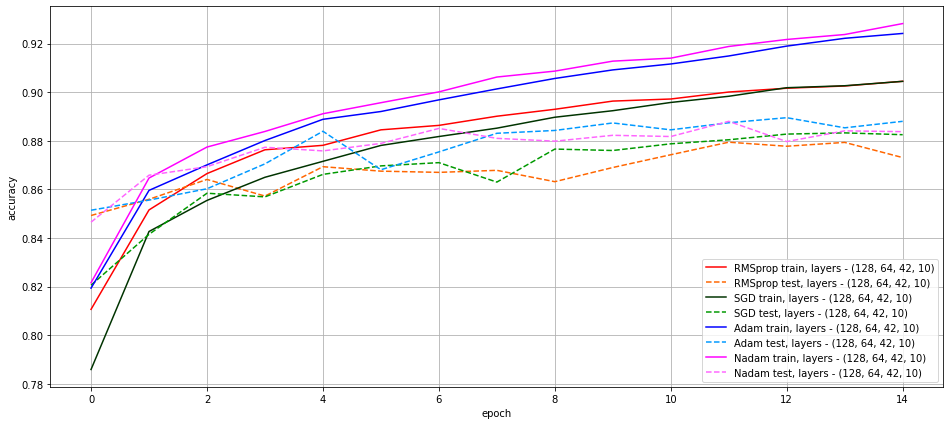

In [12]:
plt.figure(figsize=(16,7))

model_fashion_mnist(model_3, layers_3, '-', multi_optimizer=True)

plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

#### Здесь мы явно видим, что на обучающей выборке два оптимизатора Adam и Nadam отработали лучше всего, также как и на тестовой.

#### Построим матрицу ошибок

In [13]:
predict = model_10.predict(test_images)
predict = np.argmax(predict, axis=1)
confusion_matrix_10 = confusion_matrix(test_labels, predict)

In [14]:
report_hw2 = classification_report(test_labels, predict)
%store report_hw2

Stored 'report_hw2' (str)


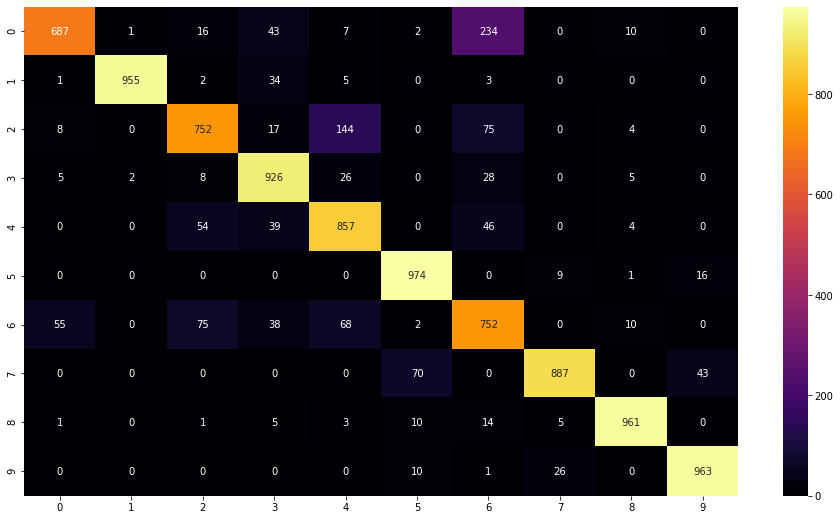

In [15]:
np.set_printoptions(precision=2)
plt.figure(figsize=(16,9))

ax = sns.heatmap(confusion_matrix_10, annot=True, fmt='g', cmap='inferno');

plt.show()

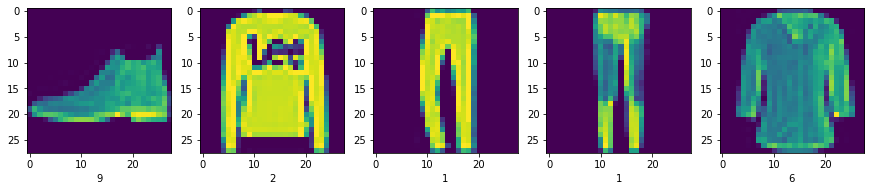

In [16]:
n = 5

y_pred = model_10.predict(test_images[:n,:])
y_pred_class = np.argmax(y_pred,axis=1)

plt.figure(figsize =(3*n,5))

for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(test_images[i,:].reshape(28,28))
    plt.xlabel(str(y_pred_class[i]))

plt.show()

#### Выводы: достичь более высокого показателя точности нам позволили в основном выбор оптимизатора. Увеличение количества нейронов и слоев в сети не дало ожидаемого увеличения точности модели.